In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from helpers import dataset, plots, image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import utils, tf_helpers
utils.setup_logging()
tf_helpers.print_versions()

Tensorflow: 2.2.0
GPUs: []


In [3]:
data = dataset.Dataset('data/raw/training_data/D90/', n_images=10, v_images=10, val_n_patches=4, load='xy')

Loading images: 100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


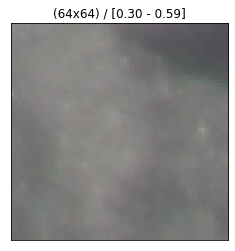

In [8]:
from models import jpeg
from models.layers import Quantization

np.random.seed(1)
batch_raw, batch_rgb = data.next_training_batch(0, 1, 64)
plots.images(batch_rgb)

(768, 8, 8)
Entropy: 6.961818954476899
TF-entropy: 5.435756683349609
1.0
5.43538674801
5.45346286334


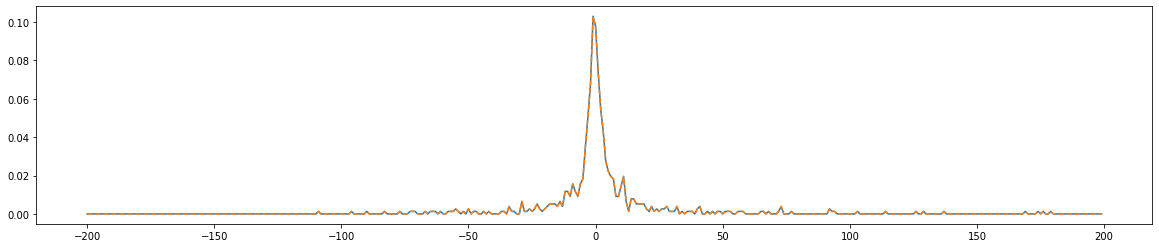

In [143]:
from helpers import stats
import matplotlib.pyplot as plt

codec = jpeg.DifferentiableJPEG(100, 'soft')
batch_y = data.next_validation_batch(9, 1)[-1]


batch_Y, batch_Z = codec(batch_y)
print(batch_Z.shape)

Z = batch_Z[:, 0, 1].numpy().reshape((1, -1))
C = np.arange(-200,200)

tf_entropy, tf_hist, tf_weights = tf_helpers.entropy(Z, C.reshape((1, -1)), v=50, gamma=25)

# plots.images(batch_Y.numpy(), figwidth=7)

plots.hist(Z, 50, '0,1')

p = stats.hist(Z, C, density=True)

plt.figure(figsize=(20, 4))
plt.plot(C, p)
plt.plot(C, tf_hist, '--')

print(f'Entropy: {stats.entropy(Z, C)}')
print(f'TF-entropy: {tf_entropy}')

print(np.sum(p))
print(-np.sum(tf_hist * np.log2(tf_hist)))
print(-np.sum(tf_hist * np.log2(p + 1e-12)))


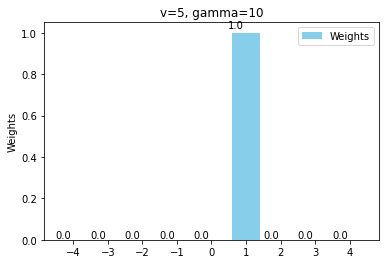

In [43]:
values = tf.convert_to_tensor([1])
v = 5
gamma = 10
codebook = tf.convert_to_tensor(np.array([-4, -3, -2, -1, 0, 1,2,3, 4]).reshape([1, -1]))
entropy, histogram, weight = tf_helpers.entropy(values, codebook, v=v, gamma=gamma)

#print(entropy)
#print(weight)


x_vals = codebook.numpy().reshape(9)
y_vals = np.round(weight[0][:].numpy().reshape(9),3)
fig, ax = plt.subplots()
rects1 = ax.bar(x_vals, y_vals,color='SkyBlue', label='Weights')

#Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weights')
ax.set_title(f'v={v}, gamma={gamma}')
ax.set_xticks(x_vals)
ax.legend()

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "left")

plt.show()


In [138]:
# Experiment1: original settings
# bpf=9

epochs =300
opt = tf.keras.optimizers.Adam(1e-1)
weight = 20

codec_differentiable = jpeg.JPEG(100, codec='soft', trainable=True)
# codec_differentiable.set_v_and_g(v=5, g=5)
codec_differentiable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=9)


# loss if you don't train q tables
codec_differentiable_untrainable = jpeg.JPEG(50, codec='soft', trainable=None)
codec_differentiable_untrainable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=9)
batch_y_untrainable, entropy_untrainable = codec_differentiable_untrainable.process(batch_rgb, return_entropy=True)

# distortion_loss_untrainable = tf.reduce_mean(tf.math.pow(255*batch_y_untrainable-255*batch_rgb, 2.0)) 
# total_untrainable_loss = distortion_loss_untrainable + weight * entropy_untrainable
# print(f'untrainable-->{total_untrainable_loss:.2f} {distortion_loss_untrainable:.2f} {entropy_untrainable:.2f}')

C = np.arange(-200,200).reshape((1, -1))

x = []
y = []
y_entropy=[]
y_distortion =[]
cnt = 0
min_loss = 1000000
optimal_parameters = tf.Variable(0.0)

for i in range(0, epochs):
    with tf.GradientTape() as tape:
        batch_y, Z = codec_differentiable.process(batch_rgb, return_entropy=True)
        entropy = tf_helpers.entropy(Z, C, v=1, gamma=5)[0]
        distortion_loss = tf.reduce_mean(tf.math.pow(255*batch_y-255*batch_rgb, 2.0))
        #loss = distortion_loss + weight*entropy
        loss = entropy
        x.append(int(i+1))
        y.append(loss.numpy())
        y_entropy.append(weight*entropy.numpy())
        y_distortion.append(distortion_loss.numpy())

#         if loss<min_loss:
#             min_loss = loss
#             optimial_parameters = codec_differentiable.parameters
#             cnt =0
#         else:
#             cnt +=1
#         if entropy>entropy_untrainable and cnt>=50:
#             break
    grad = tape.gradient(loss, codec_differentiable.parameters)
    
    grad = [x/(1e-12 + tf.linalg.norm(x)) for x in grad]
    
    opt.apply_gradients(zip(grad, codec_differentiable.parameters))
    
    qf = codec_differentiable.estimate_qf(0)
    
    qt = codec_differentiable._model._q_mtx_luma

    print(f'{i:03d} --> {loss:.2f} {distortion_loss:.2f} {entropy:.2f} {qf} {qt[0, 0]} {qt[0, 1]}')
    #if i%10==0:
    #print(grad)
    
plt.plot(x, y, 'r', label='total loss')
plt.plot(x, y_entropy, 'g', label='weight*entropy')
plt.plot(x, y_distortion, 'b', label='distortion')
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
min_val = min(y+y_entropy+y_distortion)
max_val = max(y+y_entropy+y_distortion)
print(min_val)
print(max_val)
plt.ylim(min_val-2,max_val+2)
plt.legend()
plt.show()

000 --> 2.47 0.20 2.47 100 1.0999996662139893 0.9000033736228943
001 --> 2.52 0.18 2.52 100 1.200110912322998 0.80930495262146
002 --> 2.54 0.17 2.54 100 1.3003677129745483 0.7509253025054932
003 --> 2.54 0.17 2.54 100 1.4005273580551147 0.7368554472923279
004 --> 2.54 0.17 2.54 100 1.5002717971801758 0.6871668100357056
005 --> 2.53 0.17 2.53 100 1.5776593685150146 0.6210786700248718
006 --> 2.52 0.17 2.52 100 1.646213173866272 0.5444530844688416
007 --> 2.51 0.17 2.51 100 1.6933016777038574 0.4607672393321991
008 --> 2.52 0.17 2.52 100 1.7213305234909058 0.3722378611564636
009 --> 2.51 0.17 2.51 100 1.7630188465118408 0.3066220283508301
010 --> 2.52 0.17 2.52 100 1.8103176355361938 0.23223631083965302
011 --> 2.52 0.17 2.52 100 1.8600263595581055 0.19545114040374756
012 --> 2.52 0.17 2.52 100 1.8953135013580322 0.185281440615654
013 --> 2.52 0.17 2.52 100 1.9302407503128052 0.1954289972782135
014 --> 2.52 0.17 2.52 100 1.972830057144165 0.22016946971416473
015 --> 2.52 0.17 2.52 100 2

KeyboardInterrupt: 

In [142]:
print(tf.linalg.norm(grad[0]))
print(grad[0].numpy().round(2))

tf.Tensor(1.0, shape=(), dtype=float32)
[[ 0.23 -0.94  0.04  0.02 -0.01  0.    0.    0.  ]
 [-0.21 -0.02  0.   -0.   -0.   -0.    0.   -0.01]
 [ 0.02  0.01  0.01 -0.   -0.02 -0.   -0.01  0.  ]
 [ 0.02 -0.05  0.   -0.01  0.    0.    0.   -0.  ]
 [-0.   -0.   -0.03  0.01  0.   -0.    0.02  0.  ]
 [ 0.    0.    0.02  0.01  0.    0.    0.01  0.  ]
 [-0.   -0.    0.   -0.   -0.    0.    0.01  0.  ]
 [ 0.   -0.   -0.01  0.01 -0.    0.02  0.01  0.01]]


In [131]:
entropy = tf_helpers.entropy(Z, C)[0]

In [141]:
codec_differentiable._model._q_mtx_luma.numpy().round(2)

array([[ 2.24,  0.12,  0.68,  0.83,  0.84,  0.96,  0.81,  0.8 ],
       [ 0.35,  2.09,  0.99,  1.08,  0.75,  1.06,  1.  ,  0.76],
       [ 1.98,  1.11,  0.6 ,  0.84,  0.86,  0.82,  0.86,  0.91],
       [ 1.65,  0.83,  0.8 ,  0.78,  1.02,  0.93,  0.97,  0.96],
       [ 0.97,  1.06,  0.81,  0.84,  0.82,  0.75,  0.64,  0.76],
       [ 0.99,  0.98,  0.73,  0.51,  1.16,  0.75,  0.77,  0.98],
       [ 0.88,  0.76,  0.98,  1.05,  1.15,  0.96,  0.55,  0.89],
       [ 0.84,  0.61,  0.28,  0.6 ,  0.67,  0.55,  0.39,  0.5 ]], dtype=float32)

In [ ]:
# Experiment2:
# bpf=5
# eps=1e-72
# batch_size=10
epochs =1000
opt = tf.keras.optimizers.Adam(1)
codec_differentiable = jpeg.JPEG(50, codec='sin', trainable=True)
codec_differentiable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=5)


weight = 10
codec_differentiable_untrainable = jpeg.JPEG(50, codec='sin', trainable=None)
codec_differentiable_untrainable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=5)
batch_y_untrainable, entropy_untrainable = codec_differentiable_untrainable.process(batch_rgb, return_entropy=True)
distortion_loss_untrainable = tf.reduce_mean(tf.math.pow(255*batch_y_untrainable-255*batch_rgb, 2.0)) 
total_untrainable_loss = distortion_loss_untrainable + weight * entropy_untrainable
print(f'untrainable-->{total_untrainable_loss:.2f} {distortion_loss_untrainable:.2f} {entropy_untrainable:.2f}')


x = []
y = []
y_entropy=[]
y_distortion =[]
cnt = 0
min_loss = 1000000
optimal_parameters = tf.Variable(0.0)

for i in range(0, epochs):
    with tf.GradientTape() as tape:
        batch_y, entropy = codec_differentiable.process(batch_rgb, return_entropy=True)
        distortion_loss = tf.reduce_mean(tf.math.pow(255*batch_y-255*batch_rgb, 2.0))
        #loss = distortion_loss + weight*entropy
        #loss = 100*distortion_loss + weight*tf.math.pow(100*entropy-100*0.74, 2.0)
        loss = entropy
        x.append(int(i+1))
        y.append(loss.numpy())
        y_entropy.append(10*entropy.numpy())
        y_distortion.append(distortion_loss.numpy())
        
#         if loss<min_loss:
#             min_loss = loss
#             optimial_parameters = codec_differentiable.parameters
#             cnt =0
#         else:
#             cnt +=1
#         if entropy>entropy_untrainable and cnt>=50:
#             break
            
    grad = tape.gradient(loss, codec_differentiable.parameters)
    opt.apply_gradients(zip(grad, codec_differentiable.parameters))
    print(f'{i:03d}-->{loss:.2f} {distortion_loss:.2f} {entropy:.2f}')

    print(grad)

plt.plot(x, y, 'r', label='total loss')
plt.plot(x, y_entropy, 'g', label='weight*entropy')
plt.plot(x, y_distortion, 'b', label='distortion')
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
print(codec_differentiable._model._q_mtx_luma.numpy().round(3))
print(codec_differentiable._model._q_mtx_chroma.numpy().round(3))
codec_differentiable.summary()


In [ ]:
# Experiment3:  init at 100
# bpf=5
# eps=1e-72
# batch_size=1
# bpf=5
# eps=1e-72
# batch_size=1

epochs =10000
opt = tf.keras.optimizers.Adam(1)
weight = 10
x = []
y = []
y_entropy=[]
y_distortion =[]
cnt = 0
min_loss = 1000000
optimal_parameters = tf.Variable(0.0)


codec_differentiable = jpeg.JPEG(50, codec='sin', trainable=True)
codec_differentiable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=5)

codec_differentiable._model._q_mtx_luma = tf.Variable(100*tf.ones([8, 8], dtype=tf.dtypes.float32))
codec_differentiable._model._q_mtx_chroma = tf.Variable(100*tf.ones([8, 8], dtype=tf.dtypes.float32))
print(codec_differentiable._model._q_mtx_luma)
print(codec_differentiable._model._q_mtx_chroma)


codec_differentiable_untrainable = jpeg.JPEG(50, codec='sin', trainable=None)
codec_differentiable_untrainable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=5)
batch_y_untrainable, entropy_untrainable = codec_differentiable_untrainable.process(batch_rgb, return_entropy=True)
distortion_loss_untrainable = tf.reduce_mean(tf.math.pow(255*batch_y_untrainable-255*batch_rgb, 2.0)) 
total_untrainable_loss = distortion_loss_untrainable + weight * entropy_untrainable
print(f'untrainable-->{total_untrainable_loss:.2f} {distortion_loss_untrainable:.2f} {entropy_untrainable:.2f}')


loss=0

for i in range(0, epochs):
    with tf.GradientTape() as tape:
        batch_y, entropy = codec_differentiable.process(batch_rgb, return_entropy=True)
        distortion_loss = tf.reduce_mean(tf.math.pow(255*batch_y-255*batch_rgb, 2.0))
#        loss = distortion_loss + weight*tf.math.pow(100*entropy-100*entropy_untrainable, 2.0)
#        loss = 10*entropy
        loss = distortion_loss + weight*entropy
#        loss = distortion_loss + weight*entropy-0.00001*tf.reduce_sum(codec_differentiable.parameters)
#        loss = weight*tf.math.pow(100*entropy-100*tf.constant(entropy_untrainable), 2.0)
        x.append(int(i+1))
        y.append(loss.numpy())
        y_entropy.append(10*entropy.numpy())
        y_distortion.append(distortion_loss.numpy())
        
            
#         if loss<min_loss:
#             min_loss = loss
#             optimial_parameters = codec_differentiable.parameters
#             cnt =0
#         else:
#             cnt +=1
#         if entropy>entropy_untrainable and cnt>=50:
#             break
    grad = tape.gradient(loss, codec_differentiable.parameters)
    opt.apply_gradients(zip(grad, codec_differentiable.parameters))
    
    print(f'{i:03d}-->{loss:.2f} {distortion_loss:.2f} {entropy:.2f}')
#    print(grad)
#    print(codec_differentiable.parameters)

plt.plot(x, y, 'r', label='total loss')
plt.plot(x, y_entropy, 'g', label='weight*entropy')
plt.plot(x, y_distortion, 'b', label='distortion')
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
codec_differentiable._model._q_mtx_luma.numpy().round(3)
codec_differentiable._model._q_mtx_chroma.numpy().round(3)

In [ ]:
# Experiment4:  init at 100
# bpf=5
# eps=1e-72
# batch_size=1
# bpf=5
# eps=1e-72
# batch_size=1
# entropy loss l2 constrainted to target entropy
epochs =10000
opt = tf.keras.optimizers.Adam(1)


codec_differentiable = jpeg.JPEG(50, codec='soft', trainable=True)
codec_differentiable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=5)

codec_differentiable._model._q_mtx_luma = tf.Variable(150*tf.ones([8, 8], dtype=tf.dtypes.float32))
codec_differentiable._model._q_mtx_chroma = tf.Variable(150*tf.ones([8, 8], dtype=tf.dtypes.float32))
print(codec_differentiable._model._q_mtx_luma)
print(codec_differentiable._model._q_mtx_chroma)

weight = 30
codec_differentiable_untrainable = jpeg.JPEG(50, codec='soft', trainable=None)
codec_differentiable_untrainable._model.quantization = Quantization(codec_differentiable._model.rounding_approximation, codec_differentiable._model.rounding_approximation_steps, latent_bpf=5)
batch_y_untrainable, entropy_untrainable = codec_differentiable_untrainable.process(batch_rgb, return_entropy=True)
distortion_loss_untrainable = tf.reduce_mean(tf.math.pow(255*batch_y_untrainable-255*batch_rgb, 2.0)) 
total_untrainable_loss = distortion_loss_untrainable + weight * entropy_untrainable
print(f'untrainable-->{total_untrainable_loss:.2f} {distortion_loss_untrainable:.2f} {entropy_untrainable:.2f}')




x = []
y = []
y_entropy=[]
y_distortion =[]
cnt = 0
min_loss = 1000000
optimal_parameters = tf.Variable(0.0)

for i in range(0, epochs):
    with tf.GradientTape() as tape:
        batch_y, entropy = codec_differentiable.process(batch_rgb, return_entropy=True)
        distortion_loss = tf.reduce_mean(tf.math.pow(255*batch_y-255*batch_rgb, 2.0))
        loss = distortion_loss + weight*tf.math.pow(100*entropy-100*entropy_untrainable, 2.0)
#        loss = entropy
#        loss = distortion_loss + weight*entropy
        x.append(int(i+1))
        y.append(loss.numpy())
        y_entropy.append(10*entropy.numpy())
        y_distortion.append(distortion_loss.numpy())
        

#         if loss<min_loss:
#             min_loss = loss
#             optimial_parameters = codec_differentiable.parameters
#             cnt =0
#         else:
#             cnt +=1
#         if entropy>entropy_untrainable and cnt>=50:
#             break
    grad = tape.gradient(loss, codec_differentiable.parameters)
    opt.apply_gradients(zip(grad, codec_differentiable.parameters))
    
    print(f'{i:03d}-->{loss:.2f} {distortion_loss:.2f} {entropy:.2f}')
    #print(grad)

    
    
    
    
    
    
    
    
plt.plot(x, y, 'r', label='total loss')
plt.plot(x, y_entropy, 'g', label='weight*entropy')
plt.plot(x, y_distortion, 'b', label='distortion')
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
codec_differentiable._model._q_mtx_luma.numpy().round(3)

In [ ]:
codec_differentiable.summary()